# Problem 4 - Optimus, Learning and Resource models, Performance-cost tradeoffs(30 points)
Peng et al. proposed Optimus scheduler for deep learning clusters which makes use of a predictive model to estimate the remaining time of a training job. Optimus assumes a parameter-server architecture for distributed training where synchronization between parameter server(s) and workers happen after every training step. The time taken to complete one training step on a worker includes the time for doing forward propagation (i.e., loss computation) and backward propagation (i.e., gradients computation) at the worker, the worker pushing gradients to parameter servers, parameter servers updating parameters, and the worker pulling updated parameters from parameter servers, plus extra communication overhead.

The predictive model proposed in Optimus is based on two sub-models, one to model the training loss as a function of number of steps and the other to model the training speed (training steps per unit time) as a function of resources (number of workers and parameter servers). The training loss model is given by Equation (1) in the paper. It has three parameters β 0 , β 1 , and β 2 that needs to be estimated from the data.

**I collaborate with:**

| Name           | Contribution      |
|----------------|-------------------|
| Aneri Patel    | Resnet-18, 20 |
| Kunal Kulkarni | Resnet-32         |
| Shriya Jain    | Resnet-44         |
| Xiang Pang     | Resnet-56         |

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.optim as optim


networks = ['resnet18', 'resnet20', 'resnet32','resnet44','resnet56','resnet50']

GPU = torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device,"\n\n")

BATCH_SIZE = 128

train_transforms = transforms.Compose(
    [transforms.ToTensor(),transforms.RandomHorizontalFlip(),torchvision.
     transforms.RandomRotation((-15, +15)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform = train_transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False, num_workers=2)

classes = test_dataset.classes
# print(classes)


import torch
import torch.nn as nn
import torch.nn.functional as F


class Block_Plain(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block_Plain, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
            # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet_Plain(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet_Plain, self).__init__()
        # From table 1 in ResNet paper
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
            
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        
        for i in range(num_residual_blocks - 1):
            
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        
        return nn.Sequential(*layers)


class block(nn.Module):
    def __init__(self, filters, subsample=False):
        super().__init__()
        
        s = 0.5 if subsample else 1.0
        
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3, 
                               stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()

        # Shortcut downsampling
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)
        
    def shortcut(self, z, x):

        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            return z + torch.cat((d, p), dim=1)
        else:
            return z + x        
    
    def forward(self, x, shortcuts=False):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        
        z = self.conv2(z)
        z = self.bn2(z)
        
        if shortcuts:
            z = self.shortcut(z, x)

        z = self.relu2(z)
        
        return z
    


class ResNet(nn.Module):
    def __init__(self, n, shortcuts=True):
        super().__init__()
        self.shortcuts = shortcuts
        
        # Input
        self.convIn = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnIn   = nn.BatchNorm2d(16, track_running_stats=True)
        self.relu   = nn.ReLU()
        
        # Stack1
        self.stack1 = nn.ModuleList([block(16, subsample=False) for _ in range(n)])

        # Stack2
        self.stack2a = block(32, subsample=True)
        self.stack2b = nn.ModuleList([block(32, subsample=False) for _ in range(n-1)])

        # Stack3
        self.stack3a = block(64, subsample=True)
        self.stack3b = nn.ModuleList([block(64, subsample=False) for _ in range(n-1)])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fcOut   = nn.Linear(64, 10, bias=True)
        self.softmax = nn.LogSoftmax(dim=-1)
                
        
    def forward(self, x):     
        z = self.convIn(x)
        z = self.bnIn(z)
        z = self.relu(z)
        
        for l in self.stack1: z = l(z, shortcuts=self.shortcuts)
        
        z = self.stack2a(z, shortcuts=self.shortcuts)
        for l in self.stack2b: 
            z = l(z, shortcuts=self.shortcuts)
        
        z = self.stack3a(z, shortcuts=self.shortcuts)
        for l in self.stack3b: 
            z = l(z, shortcuts=self.shortcuts)

        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.fcOut(z)
        return self.softmax(z)



def eval_model(val_loader):
    acc = 0
    running_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        acc += (torch.sum(labels == outputs.argmax(dim=1))/BATCH_SIZE)
        vf.write('%d,%5d,%.7f,%.7f\n' % (epoch + 1, i + 1, loss.item(),acc/(i+1)))
        running_loss += loss.item()
    print('Epoch: %d, Step: %5d Val loss: %.9f, Acc: %.9f' %
        (epoch + 1, i + 1, running_loss / 50,acc/(i+1)))
    running_loss = 0.0


img_channels = 3
num_classes = 10

def create_model(n_layers, num_classes=10):
    if n_layers==18:
        net = ResNet_Plain(18, Block_Plain, img_channels, num_classes)
    elif n_layers ==20:
        net = ResNet(3, shortcuts=True)
    elif n_layers ==32:
        net = ResNet(5, shortcuts=True)
    elif n_layers ==44:
        net = ResNet(7, shortcuts=True)
    elif n_layers ==56:
        net = ResNet(9, shortcuts=True)
    # for question 4.2    
    elif n_layers==50:
        net = ResNet_Plain(50, Block_Plain, img_channels, num_classes)
    return net



EPOCH = 350

lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 
milestones = [82, 123]
gamma = 0.1


# criterion = torch.nn.NLLLoss()

criterion = nn.CrossEntropyLoss()

layers = [18,20,32,44,56,50]
networks = ["resnet"+str(i) for i in layers]

for NETWORK_ID in range(len(layers)):
    
    print(networks[NETWORK_ID])
        
    net = create_model(layers[NETWORK_ID]).to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        
#     optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
#     scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
        
    f = open(networks[NETWORK_ID]+"_"+GPU+".csv", "w")
    f.write('epoch, step, loss, acc\n')

    vf = open(networks[NETWORK_ID]+"_"+GPU+"_val.csv", "w")
    vf.write('epoch, step, loss, acc\n')

    for epoch in range(EPOCH):
        acc = 0
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            acc += (torch.sum(labels == outputs.argmax(dim=1))/BATCH_SIZE)
            f.write('%d,%5d,%.7f,%.7f\n' % (epoch + 1, i + 1, loss.item(),acc/(i+1)))
            running_loss += loss.item()


            if i % 50 == 0: # print every 50 iterations
                print('Epoch: %d, Step: %5d loss: %.9f, Acc: %.9f' %
                (epoch + 1, i + 1, running_loss / 50,acc/(i+1)))
                running_loss = 0.0
                eval_model(testloader)

#         if epoch % 50 == 49:
#             torch.save(net.state_dict(),networks[NETWORK_ID]+"_"+GPU+"_"+str(epoch+1)+".pt")

    f.close()
    vf.close()
    print('Finished Training '+ networks[NETWORK_ID])

## 1
The first step is to generate data for predictive model calibration. You will train Resnet models with different number of layers (18, 20, 32, 44, 56) each with 3 different GPU types (K80, RTX8000, V100).

For these runs you will use CIFAR10, a batch size of 128, and run each job for 350 epochs.

## Read Results

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
res_path = "./problem4/results/"
for file in os.listdir(res_path):
    if file.endswith(".csv"):
        df = pd.read_csv(res_path + file)

In [4]:
df

,epoch,step,loss,acc
0,1,1,2.494066,0.109375
1,1,2,2.732457,0.113281
2,1,3,2.677715,0.093750
3,1,4,2.687866,0.105469
4,1,5,2.569639,0.107813
...,...,...,...,...
221195,350,75,1.053012,0.761042
221196,350,76,1.522796,0.761308
221197,350,77,1.956427,0.761161
221198,350,78,1.571791,0.760918


In [5]:
from scipy.optimize import curve_fit

In [6]:
def func(k, b0, b1, b2):
    loss = 1 / (b0 * k + b1) + b2
    return loss

In [7]:
def get_model_parameters(df):
    df.columns = [s.strip() for s in df.columns]
    x = df["real_step"]
    y = df["loss"]
    popt, pcov = curve_fit(func, x, y, bounds=(0, [np.inf, np.inf, np.inf]))
    # print(popt, pcov)
    return popt, pcov
# popt, pcov = get_model_parameters(df)
# b0, b1, b2 = popt

In [8]:
def parse_model_name(name):
    name = name.replace(".csv", "")
    model_name = name.split("_")[0]
    gpu_name = name.split("_")[1]
    split = "val" if len(name.split("_")) == 3 else "train"
    return model_name, gpu_name, split

In [82]:
res_list = []
res_path = "./problem4/results/"
for file in os.listdir(res_path):
    if file.endswith(".csv"):
        df = pd.read_csv(res_path + file)
        df.columns = [s.strip() for s in df.columns]
        # print(df)
        epoch_steps = max(df[df["epoch"]==1]["step"])
        df["real_step"] = (df["epoch"] - 1) * epoch_steps + df["step"]
        
        # first step achieve 92 accuracy
        t = df[df["acc"] > 0.92]["real_step"]
        e = df[df["acc"] > 0.92]["epoch"]
        
        if len(t) > 0:
            t = t.values[0]
            e = e.values[0]
            loss_92acc = df[df["real_step"] == t]["loss"].values[0]
        else:
            t = -1
            e = -1
            loss_92acc = -1
        # print(t)
        # print(epoch_steps)
        # df["real_step"] = (df["epoch"] == 1)
        popt, pcov = get_model_parameters(df)
        model_name, gpu_name, split = parse_model_name(file)
        b0, b1, b2 = popt
        res_list.append({"model": model_name, "gpu": gpu_name, "split": split, "b0": b0, "b1": b1, "b2": b2, "epoch_to_92acc": e,"step_to_92acc": t, "loss_92acc": loss_92acc, "epoch_steps": epoch_steps})
res_df = pd.DataFrame.from_records(res_list)

In [83]:
res_df

,model,gpu,split,b0,b1,b2,epoch_to_92acc,step_to_92acc,loss_92acc,epoch_steps
0,resnet56,NVIDIA A100-PCIE-40GB,val,0.007232,5.082540e-01,5.378531e-01,48,3714,0.310703,79
1,resnet18,Tesla V100-PCIE-32GB,val,15074.454974,4.842781e-15,1.489328e+00,-1,-1,-1.000000,79
2,resnet50,Quadro RTX 8000,train,0.000237,4.595429e-01,5.166572e-18,35,13295,0.245837,391
3,resnet56,Quadro RTX 8000,val,0.006419,5.410299e-01,5.360027e-01,64,4978,0.439552,79
4,resnet50,Tesla V100-PCIE-32GB,train,0.000233,4.650595e-01,6.178933e-18,28,10558,0.258628,391
5,resnet44,Tesla V100-PCIE-32GB,val,0.006194,6.156885e-01,5.165396e-01,60,4662,0.326317,79
6,resnet50,NVIDIA A100-PCIE-40GB,train,0.000236,4.631299e-01,4.789917e-18,32,12122,0.228549,391
7,resnet18,NVIDIA A100-PCIE-40GB,train,0.000271,5.496289e-01,1.109550e-20,27,10167,0.227245,391
8,resnet20,NVIDIA A100-PCIE-40GB,train,0.000117,6.774311e-01,3.629090e-02,58,22288,0.308384,391
9,resnet20,Tesla V100-PCIE-32GB,train,0.000116,6.772954e-01,3.292359e-02,65,25025,0.278525,391


### Select Training Split

In [84]:
train_res_df = res_df[res_df["split"] == "train"]

In [85]:
train_res_df

,model,gpu,split,b0,b1,b2,epoch_to_92acc,step_to_92acc,loss_92acc,epoch_steps
2,resnet50,Quadro RTX 8000,train,0.000237,0.459543,5.166572e-18,35,13295,0.245837,391
4,resnet50,Tesla V100-PCIE-32GB,train,0.000233,0.465060,6.178933e-18,28,10558,0.258628,391
6,resnet50,NVIDIA A100-PCIE-40GB,train,0.000236,0.463130,4.789917e-18,32,12122,0.228549,391
7,resnet18,NVIDIA A100-PCIE-40GB,train,0.000271,0.549629,1.109550e-20,27,10167,0.227245,391
8,resnet20,NVIDIA A100-PCIE-40GB,train,0.000117,0.677431,3.629090e-02,58,22288,0.308384,391
9,resnet20,Tesla V100-PCIE-32GB,train,0.000116,0.677295,3.292359e-02,65,25025,0.278525,391
12,resnet56,Quadro RTX 8000,train,0.000181,0.594359,7.921437e-18,43,16423,0.234778,391
13,resnet44,Quadro RTX 8000,train,0.000164,0.629734,3.023622e-17,45,17205,0.227768,391
14,resnet32,Tesla V100-PCIE-32GB,train,0.000137,0.652959,4.390594e-16,40,15251,0.213712,391
17,resnet32,Quadro RTX 8000,train,0.000138,0.654284,1.229320e-14,49,18769,0.211670,391


## 2
We next study how the learned parameters, β 0, β 1, and β 2, change with the type of GPUs and the size of network. Use a regression model on the data from 15 models to predict the value of these parameters as a function of number of layers in Resnet and GPU type. From these regresssion model predict the training loss curve for Resnet-50. Note that we are effectively doing prediction for a predictive model. To verify how good is this prediction, you will train Resnet-50 on a K80, RTX8000, and V100 for target accuracy of 92% and compare the predicted loss curve with the real measurements. Show this comparison in a graph and calculate the percentage error. From the predicted loss curve get the number of epochs needed to achive 92% accuracy. Observe that there are three curves for three different GPU types, but the number of epochs required to reach a particular accuracy (convergence rate) should be independent of hardware. (8)

In [13]:
gpu_kinds = train_res_df["gpu"].unique()
# print(gpu_kinds)
gpu_type_mapping = {t: i for i, t in enumerate(gpu_kinds)}
# print(gpu_type_mapping)

In [14]:
res_df["gpu_type"] = res_df["gpu"].map(gpu_type_mapping)

In [15]:
def get_num_layers(model_name):
    num_layers = model_name.replace("resnet", "")
    return int(num_layers)
res_df["num_layers"] = res_df["model"].map(get_num_layers)
res_df.to_csv("./problem4/res_df.csv", index=False)

In [16]:
res_df = res_df[res_df["split"] == "train"]

In [17]:
train_res_df = res_df[res_df["num_layers"] != 50]
test_res_df = res_df[res_df["num_layers"] == 50]

In [18]:
# b0, b1, b2 = reg(num_layers, )
x0 = train_res_df["num_layers"].values
x1 = train_res_df["gpu_type"].values
X = np.array([x0, x1]).T
y0 = train_res_df["b0"].values
y1 = train_res_df["b1"].values
y2 = train_res_df["b2"].values
Y = np.array([y0, y1, y2]).T

In [33]:
X.shape

(15, 2)

In [34]:
Y.shape

(15, 3)

In [36]:
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
krr = KernelRidge(alpha=1.0)
krr.fit(X, Y)
Y_hat = krr.predict(X)
yy = np.concatenate((Y, Y_hat), axis=1)
df = pd.DataFrame(yy, columns=["b0", "b1", "b2", "b0_hat", "b1_hat", "b2_hat"])
df

,b0,b1,b2,b0_hat,b1_hat,b2_hat
0,0.000271,0.549629,1.109550e-20,0.000126,0.453489,0.008108
1,0.000117,0.677431,3.629090e-02,0.000133,0.479377,0.008108
2,0.000116,0.677295,3.292359e-02,0.000100,0.369129,0.004058
3,0.000181,0.594359,7.921437e-18,0.000189,0.724866,0.000022
4,0.000164,0.629734,3.023622e-17,0.000148,0.569538,0.000017
5,0.000137,0.652959,4.390594e-16,0.000140,0.524457,0.004063
6,0.000138,0.654284,1.229320e-14,0.000108,0.414209,0.000012
7,0.000135,0.663969,8.933287e-16,0.000173,0.634705,0.008113
8,0.000276,0.540971,5.573940e-20,0.000093,0.343241,0.004057
9,0.000274,0.547371,2.673371e-20,0.000061,0.232993,0.000007


In [37]:
# b0, b1, b2 = reg(num_layers, )
x0 = test_res_df["num_layers"].values
x1 = test_res_df["gpu_type"].values
test_X = np.array([x0, x1]).T
y0 = test_res_df["b0"].values
y1 = test_res_df["b1"].values
y2 = test_res_df["b2"].values
test_Y = np.array([y0, y1, y2]).T

In [38]:
test_res_df

,model,gpu,split,b0,b1,b2,epoch_to_92acc,step_to_92acc,loss_92acc,epoch_steps,gpu_type,num_layers
2,resnet50,Quadro RTX 8000,train,0.000237,0.459543,5.166572e-18,35,13295,0.245837,391,0,50
4,resnet50,Tesla V100-PCIE-32GB,train,0.000233,0.465060,6.178933e-18,28,10558,0.258628,391,1,50
6,resnet50,NVIDIA A100-PCIE-40GB,train,0.000236,0.463130,4.789917e-18,32,12122,0.228549,391,2,50


In [39]:
test_X

array([[50,  0],
       [50,  1],
       [50,  2]])

In [92]:
test_res_df["gpu_type"]

2    0
4    1
6    2
Name: gpu_type, dtype: int64

In [93]:
test_Y_hat = krr.predict(test_X)
yy = np.concatenate((test_Y, test_Y_hat), axis=1)
df = pd.DataFrame(yy, columns=["b0", "b1", "b2", "b0_hat", "b1_hat", "b2_hat"])
df["gpu_type"] = test_res_df["gpu_type"].values
df["num_layers"] = test_res_df["num_layers"].values
df["model"] = test_res_df["model"].values
df["gpu"] = test_res_df["gpu"].values
def get_file_name(model, gpu):
    return model + "_" + gpu + ".csv"
df["file_name"] = get_file_name(df["model"], df["gpu"])
df

,b0,b1,b2,b0_hat,b1_hat,b2_hat,gpu_type,num_layers,model,gpu,file_name
0,0.000237,0.459543,5.166572e-18,0.000168,0.647202,0.000019,0,50,resnet50,Quadro RTX 8000,resnet50_Quadro RTX 8000.csv
1,0.000233,0.465060,6.178933e-18,0.000201,0.757450,0.004070,1,50,resnet50,Tesla V100-PCIE-32GB,resnet50_Tesla V100-PCIE-32GB.csv
2,0.000236,0.463130,4.789917e-18,0.000234,0.867698,0.008120,2,50,resnet50,NVIDIA A100-PCIE-40GB,resnet50_NVIDIA A100-PCIE-40GB.csv


In [94]:
df.to_csv("./problem4/2.csv", index=False)

### Plot the three curves

In [95]:
def func(k, b0, b1, b2):
    loss = 1 / (b0 * k + b1) + b2
    return loss

In [96]:
def get_y(x, params):
    return func(x, *params)

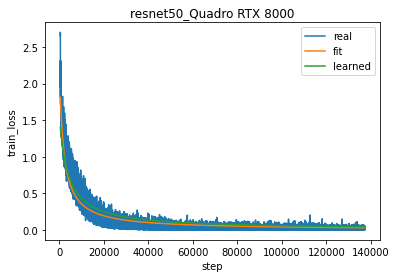

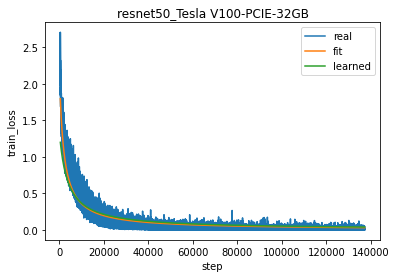

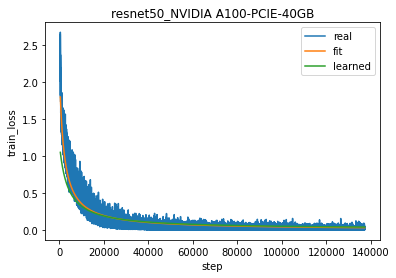

In [97]:
import matplotlib.pyplot as plt
res_path = "./problem4/results/"
for i in range(3):
    fig = plt.figure()
    temp_df = pd.read_csv("./problem4/results/" + df["file_name"][i])
    temp_df.columns = [s.strip() for s in temp_df.columns]
    
    epoch_steps = max(temp_df["step"])
    temp_df["real_step"] = temp_df["epoch"] * epoch_steps + temp_df["step"]
    real_X = temp_df["real_step"].values
    real_Y = temp_df["loss"].values
    plt.plot(real_X, real_Y, label="real")
    
    b0 = df["b0"][i]
    b1 = df["b1"][i]
    b2 = df["b2"][i]
    fit_X = real_X
    fit_Y = get_y(fit_X, (b0, b1, b2))
    plt.plot(fit_X, fit_Y, label="fit")
    
    b0_hat = df["b0_hat"][i]
    b1_hat = df["b1_hat"][i]
    b2_hat = df["b2_hat"][i]
    learned_X = real_X
    learned_Y = get_y(learned_X, (b0_hat, b1_hat, b2_hat))
    plt.plot(learned_X, learned_Y, label="learned")
    plt.xlabel("step")
    plt.ylabel("train_loss")
    plt.title(df["file_name"][i].replace(".csv", ""))
    plt.legend()
    plt.show()

### Parameter Error

In [98]:
params_list = ["b0", "b1", "b2"]
for p in params_list:
    df[f"{p}_percentage_error"] = df[f"{p}"] - df[f"{p}_hat"] / df[f"{p}"]
    df[f"{p}_absolut_error"] = df[f"{p}"] - df[f"{p}_hat"]
df

,b0,b1,b2,b0_hat,b1_hat,b2_hat,gpu_type,num_layers,model,gpu,file_name,b0_percentage_error,b0_absolut_error,b1_percentage_error,b1_absolut_error,b2_percentage_error,b2_absolut_error
0,0.000237,0.459543,5.166572e-18,0.000168,0.647202,0.000019,0,50,resnet50,Quadro RTX 8000,resnet50_Quadro RTX 8000.csv,-0.710173,0.000069,-0.948817,-0.187659,-3.738277e+12,-0.000019
1,0.000233,0.465060,6.178933e-18,0.000201,0.757450,0.004070,1,50,resnet50,Tesla V100-PCIE-32GB,resnet50_Tesla V100-PCIE-32GB.csv,-0.862069,0.000032,-1.163657,-0.292390,-6.586309e+14,-0.004070
2,0.000236,0.463130,4.789917e-18,0.000234,0.867698,0.008120,2,50,resnet50,NVIDIA A100-PCIE-40GB,resnet50_NVIDIA A100-PCIE-40GB.csv,-0.992541,0.000002,-1.410422,-0.404568,-1.695219e+15,-0.008120


### Loss Estimation Percentage Error Over Steps

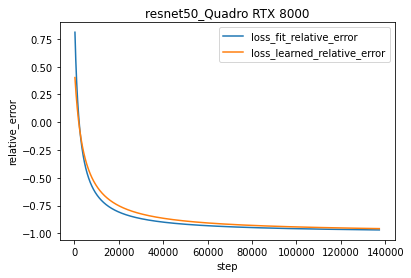

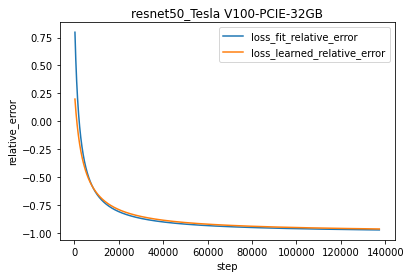

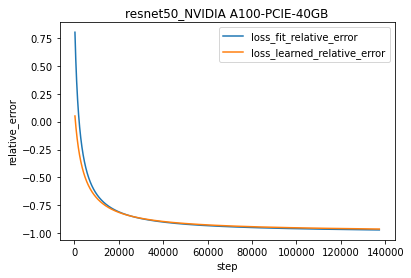

In [138]:
import matplotlib.pyplot as plt
res_path = "./problem4/results/"
for i in range(3):
    fig = plt.figure()
    temp_df = pd.read_csv("./problem4/results/" + df["file_name"][i])
    temp_df.columns = [s.strip() for s in temp_df.columns]
    
    epoch_steps = max(temp_df["step"])
    temp_df["real_step"] = temp_df["epoch"] * epoch_steps + temp_df["step"]
    real_X = temp_df["real_step"].values
    real_Y = temp_df["loss"].values
    
    b0 = df["b0"][i]
    b1 = df["b1"][i]
    b2 = df["b2"][i]
    fit_X = real_X
    fit_Y = get_y(fit_X, (b0, b1, b2))
    fit_percentage_error = fit_Y - real_Y / real_Y
    fit_absolut_error = fit_Y - real_Y
    
    b0_hat = df["b0_hat"][i]
    b1_hat = df["b1_hat"][i]
    b2_hat = df["b2_hat"][i]
    learned_X = real_X
    learned_Y = get_y(learned_X, (b0_hat, b1_hat, b2_hat))
    learned_percentage_error = learned_Y - real_Y / real_Y
    learned_absolut_error = learned_Y - real_Y
    
    plt.plot(real_X, fit_percentage_error, label="loss_fit_relative_error")
    # plt.plot(real_X, fit_absolut_error, label="real")
    plt.plot(real_X, learned_percentage_error, label="loss_learned_relative_error")
    # plt.plot(real_X, learned_absolut_error, label="learned_absolut_error")
    # plt.plot
    plt.legend()
    plt.title(df["file_name"][i].replace(".csv", ""))
    plt.xlabel("step")
    plt.ylabel("relative_error")
    plt.show()

### Loss Estimation Absolute Error Over Steps

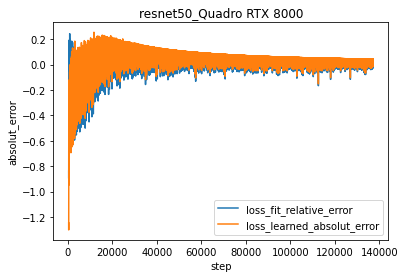

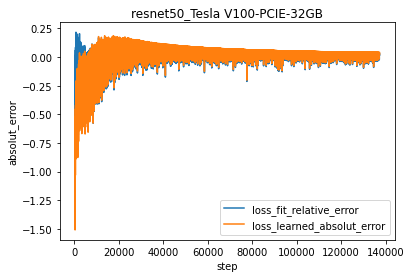

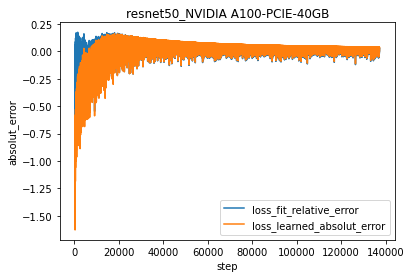

In [139]:
import matplotlib.pyplot as plt
res_path = "./problem4/results/"
for i in range(3):
    fig = plt.figure()
    temp_df = pd.read_csv("./problem4/results/" + df["file_name"][i])
    temp_df.columns = [s.strip() for s in temp_df.columns]
    
    epoch_steps = max(temp_df["step"])
    temp_df["real_step"] = temp_df["epoch"] * epoch_steps + temp_df["step"]
    real_X = temp_df["real_step"].values
    real_Y = temp_df["loss"].values
    
    b0 = df["b0"][i]
    b1 = df["b1"][i]
    b2 = df["b2"][i]
    fit_X = real_X
    fit_Y = get_y(fit_X, (b0, b1, b2))
    fit_percentage_error = fit_Y - real_Y / real_Y
    fit_absolut_error = fit_Y - real_Y
    
    b0_hat = df["b0_hat"][i]
    b1_hat = df["b1_hat"][i]
    b2_hat = df["b2_hat"][i]
    learned_X = real_X
    learned_Y = get_y(learned_X, (b0_hat, b1_hat, b2_hat))
    learned_percentage_error = learned_Y - real_Y / real_Y
    learned_absolut_error = learned_Y - real_Y
    
    plt.plot(real_X, fit_absolut_error, label="loss_fit_relative_error")
    # plt.plot(real_X, fit_absolut_error, label="real")
    plt.plot(real_X, learned_absolut_error, label="loss_learned_absolut_error")
    # plt.plot(real_X, learned_absolut_error, label="learned_absolut_error")
    # plt.plot
    plt.legend()
    plt.title(df["file_name"][i].replace(".csv", ""))
    plt.xlabel("step")
    plt.ylabel("absolut_error")
    plt.show()

### Comment
We do not know the clear definition of the percentage error. We plot both the relative error and the absolute error over steps. 

For fit, it means we use the real loss fitted curve, and calculate the error. For learned, it means we use the curve parameter learning model to get the curve parameters, and calculate the error.

We can notice that the three types of gpu do not have clearn difference in the percentage error.

#### Epoch to Reach 92%
From the predicted loss curve get the number of epochs needed to achive 92% accuracy.

In [101]:
res_df

,model,gpu,split,b0,b1,b2,epoch_to_92acc,step_to_92acc,loss_92acc,epoch_steps
0,resnet56,NVIDIA A100-PCIE-40GB,val,0.007232,5.082540e-01,5.378531e-01,48,3714,0.310703,79
1,resnet18,Tesla V100-PCIE-32GB,val,15074.454974,4.842781e-15,1.489328e+00,-1,-1,-1.000000,79
2,resnet50,Quadro RTX 8000,train,0.000237,4.595429e-01,5.166572e-18,35,13295,0.245837,391
3,resnet56,Quadro RTX 8000,val,0.006419,5.410299e-01,5.360027e-01,64,4978,0.439552,79
4,resnet50,Tesla V100-PCIE-32GB,train,0.000233,4.650595e-01,6.178933e-18,28,10558,0.258628,391
5,resnet44,Tesla V100-PCIE-32GB,val,0.006194,6.156885e-01,5.165396e-01,60,4662,0.326317,79
6,resnet50,NVIDIA A100-PCIE-40GB,train,0.000236,4.631299e-01,4.789917e-18,32,12122,0.228549,391
7,resnet18,NVIDIA A100-PCIE-40GB,train,0.000271,5.496289e-01,1.109550e-20,27,10167,0.227245,391
8,resnet20,NVIDIA A100-PCIE-40GB,train,0.000117,6.774311e-01,3.629090e-02,58,22288,0.308384,391
9,resnet20,Tesla V100-PCIE-32GB,train,0.000116,6.772954e-01,3.292359e-02,65,25025,0.278525,391


In [102]:
train_res_df = res_df[res_df["split"] == "train"]

In [103]:
train_res_df

,model,gpu,split,b0,b1,b2,epoch_to_92acc,step_to_92acc,loss_92acc,epoch_steps
2,resnet50,Quadro RTX 8000,train,0.000237,0.459543,5.166572e-18,35,13295,0.245837,391
4,resnet50,Tesla V100-PCIE-32GB,train,0.000233,0.465060,6.178933e-18,28,10558,0.258628,391
6,resnet50,NVIDIA A100-PCIE-40GB,train,0.000236,0.463130,4.789917e-18,32,12122,0.228549,391
7,resnet18,NVIDIA A100-PCIE-40GB,train,0.000271,0.549629,1.109550e-20,27,10167,0.227245,391
8,resnet20,NVIDIA A100-PCIE-40GB,train,0.000117,0.677431,3.629090e-02,58,22288,0.308384,391
9,resnet20,Tesla V100-PCIE-32GB,train,0.000116,0.677295,3.292359e-02,65,25025,0.278525,391
12,resnet56,Quadro RTX 8000,train,0.000181,0.594359,7.921437e-18,43,16423,0.234778,391
13,resnet44,Quadro RTX 8000,train,0.000164,0.629734,3.023622e-17,45,17205,0.227768,391
14,resnet32,Tesla V100-PCIE-32GB,train,0.000137,0.652959,4.390594e-16,40,15251,0.213712,391
17,resnet32,Quadro RTX 8000,train,0.000138,0.654284,1.229320e-14,49,18769,0.211670,391


We use the average loss to 92% accuracy as the estimate of loss to reach the accuracy.

In [59]:
threshold = train_res_df["loss_92acc"].mean()

In [104]:
threshold

0.23441231666666665

In [110]:
df

,b0,b1,b2,b0_hat,b1_hat,b2_hat,gpu_type,num_layers,model,gpu,file_name,b0_percentage_error,b0_absolut_error,b1_percentage_error,b1_absolut_error,b2_percentage_error,b2_absolut_error
0,0.000237,0.459543,5.166572e-18,0.000168,0.647202,0.000019,0,50,resnet50,Quadro RTX 8000,resnet50_Quadro RTX 8000.csv,-0.710173,0.000069,-0.948817,-0.187659,-3.738277e+12,-0.000019
1,0.000233,0.465060,6.178933e-18,0.000201,0.757450,0.004070,1,50,resnet50,Tesla V100-PCIE-32GB,resnet50_Tesla V100-PCIE-32GB.csv,-0.862069,0.000032,-1.163657,-0.292390,-6.586309e+14,-0.004070
2,0.000236,0.463130,4.789917e-18,0.000234,0.867698,0.008120,2,50,resnet50,NVIDIA A100-PCIE-40GB,resnet50_NVIDIA A100-PCIE-40GB.csv,-0.992541,0.000002,-1.410422,-0.404568,-1.695219e+15,-0.008120


In [112]:
test_res_df

,model,gpu,split,b0,b1,b2,epoch_to_92acc,step_to_92acc,loss_92acc,epoch_steps,gpu_type,num_layers
2,resnet50,Quadro RTX 8000,train,0.000237,0.459543,5.166572e-18,35,13295,0.245837,391,0,50
4,resnet50,Tesla V100-PCIE-32GB,train,0.000233,0.465060,6.178933e-18,28,10558,0.258628,391,1,50
6,resnet50,NVIDIA A100-PCIE-40GB,train,0.000236,0.463130,4.789917e-18,32,12122,0.228549,391,2,50


In [130]:
df

,b0,b1,b2,b0_hat,b1_hat,b2_hat,gpu_type,num_layers,model,gpu,file_name,b0_percentage_error,b0_absolut_error,b1_percentage_error,b1_absolut_error,b2_percentage_error,b2_absolut_error
0,0.000237,0.459543,5.166572e-18,0.000168,0.647202,0.000019,0,50,resnet50,Quadro RTX 8000,resnet50_Quadro RTX 8000.csv,-0.710173,0.000069,-0.948817,-0.187659,-3.738277e+12,-0.000019
1,0.000233,0.465060,6.178933e-18,0.000201,0.757450,0.004070,1,50,resnet50,Tesla V100-PCIE-32GB,resnet50_Tesla V100-PCIE-32GB.csv,-0.862069,0.000032,-1.163657,-0.292390,-6.586309e+14,-0.004070
2,0.000236,0.463130,4.789917e-18,0.000234,0.867698,0.008120,2,50,resnet50,NVIDIA A100-PCIE-40GB,resnet50_NVIDIA A100-PCIE-40GB.csv,-0.992541,0.000002,-1.410422,-0.404568,-1.695219e+15,-0.008120


In [120]:
threshold = test_res_df["loss_92acc"].mean()

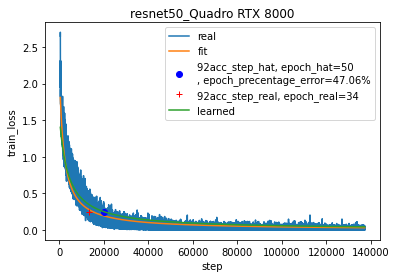

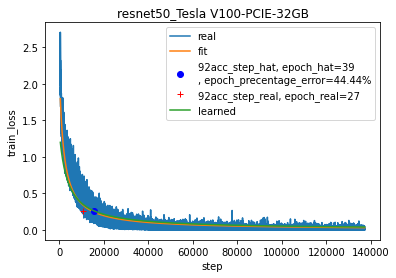

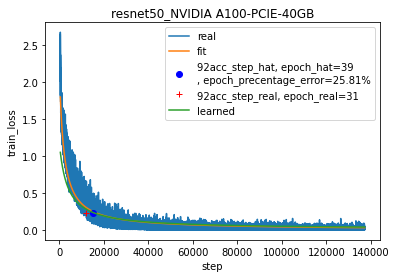

In [136]:
import matplotlib.pyplot as plt
res_path = "./problem4/results/"
for i in range(3):
    fig = plt.figure()
    temp_df = pd.read_csv("./problem4/results/" + df["file_name"][i])
    temp_df.columns = [s.strip() for s in temp_df.columns]
    
    epoch_steps = max(temp_df["step"])
    temp_df["real_step"] = temp_df["epoch"] * epoch_steps + temp_df["step"]
    real_X = temp_df["real_step"].values
    real_Y = temp_df["loss"].values
    plt.plot(real_X, real_Y, label="real")
    
    b0 = df["b0"][i]
    b1 = df["b1"][i]
    b2 = df["b2"][i]
    fit_X = real_X
    fit_Y = get_y(fit_X, (b0, b1, b2))
    plt.plot(fit_X, fit_Y, label="fit")
    
    b0_hat = df["b0_hat"][i]
    b1_hat = df["b1_hat"][i]
    b2_hat = df["b2_hat"][i]
    learned_X = real_X
    learned_Y = get_y(learned_X, (b0_hat, b1_hat, b2_hat))
    
    step_real = test_res_df["step_to_92acc"].to_list()[i]
    # print(step_real)
    loss_92acc_real = test_res_df["loss_92acc"].to_list()[i]
    # print(step_real)
    # step_hat = 
    threshold = test_res_df["loss_92acc"].to_list()[i]
    step_hat = np.where(learned_Y==learned_Y[learned_Y<threshold][0])[0][0]
    num_steps_per_epoch = 391
    epoch_hat = step_hat // num_steps_per_epoch
    epoch_real = step_real // num_steps_per_epoch
    p = "{0:.2f}".format((epoch_hat-epoch_real)/epoch_real * 100)
    plt.plot(step_hat, learned_Y[step_hat], "bo", label=f"92acc_step_hat, epoch_hat={epoch_hat} \n, epoch_precentage_error={p}%")
    plt.plot(step_real, loss_92acc_real, "r+", label=f"92acc_step_real, epoch_real={epoch_real}")
    
    plt.plot(learned_X, learned_Y, label="learned")
    plt.xlabel("step")
    plt.ylabel("train_loss")
    plt.title(df["file_name"][i].replace(".csv", ""))
    plt.legend()
    plt.show()

### Comment

The Learned curve precentage error is not that small, one reason is that we use the the kernel regression which may not extrapolate well, another reason is that the loss curve is not smooth.
Actraully, the total epoch is quite small, if we check the results over all the running epoch numbers, it is quite good.

Some discussions with students: For the regression model, I use the GPU type as the categorical feature, and they may use different regression model for different GPU types, the leaned regression model maybe more accurate if we learn the model seperately.

### 3
Using the predicted number of epochs for Resnet-50 along with the resource-speed model (use Equation (4) in Peng et al. along with its coefficients from the paper) obtain the time to accuracy of Resnet-50 (to reach 92% accuracy) in two different setting (with 2 and 4 parameter servers respectively) as a function of the number of workers. So you will be plotting two curves, one for 2 and one for 4 parameter server case. Each smooth curve will show how the time to achieve 92% accuracy (on the y-axis) scales with number of workers (on the x-axis). (7)

Hint: The theta values are given in the paper. You may re-use them directly

\begin{equation}
f(p, w)=\left(\theta_{0} \cdot \frac{M}{w}+\theta_{1}+\theta_{2} \cdot \frac{w}{p}+\theta_{3} \cdot w+\theta_{4} \cdot p\right)^{-1}
\end{equation}

|  | theta_(1) | theta_(2) | theta_(3) | theta_(4) | theta_(5) | Residual sum of squares for fitting |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| Async | 2.83 | 3.92 | 0.00 | 0.11 | - | 0.10 |
| Sync | 1.02 | 2.78 | 4.92 | 0.00 | 0.02 | 0.00 |

In [265]:
M = 128

def f_async(w, p):
    theta_0 = 2.83
    theta_1 = 3.92
    theta_2 = 0.00
    theta_3 = 0.11
    # theta_4 = 0.02
    return theta_0 * M / w + theta_1 + theta_2 * w / p + theta_3 * w

def f_sync(w, p):
    theta_0 = 1.02
    theta_1 = 2.78
    theta_2 = 4.92
    theta_3 = 0.00
    theta_4 = 0.02
    return 1 / (theta_0 * M / w + theta_1 + theta_2 * w / p + theta_3 * w + theta_4 * p)

In [266]:
def get_time(w, p):
    return epoch_hat / f_sync(w, p)

def get_time_p2(w, p=2):
    return epoch_hat / f_sync(w, p)

def get_time_p4(w, p=4):
    return epoch_hat / f_sync(w, p)

In [267]:
w = np.arange(1, M, 1)
t2 = [get_time_p2(w_i) for w_i in w]
t4 = [get_time_p4(w_i) for w_i in w]

Text(0.5, 1.0, 'time to 92% accuracy vs number of workers(w)')

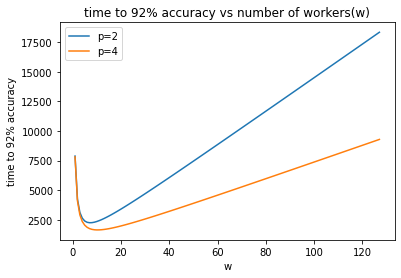

In [268]:
# plot
plt.plot(w, t2, label="p=2")
plt.plot(w, t4, label="p=4")
plt.legend()
plt.xlabel("w")
plt.ylabel("time to 92% accuracy")
plt.title("time to 92% accuracy vs number of workers(w)")